In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense, Dropout

import cv2
import pandas as pd
import dlib

In [2]:
for i in range(1000):
    globals()['land'+str(i)] = pd.read_csv('./dlib1000/train/%s.csv'%i)
    globals()['land'+str(i)] = np.array(globals()['land'+str(i)])
    
    tr_x = globals()['land'+str(i)][:, 0]
    tr_y = globals()['land'+str(i)][:, 1]
    
    tr_cx = ((min(tr_x)+max(tr_x)) / 2)        #dlib_rect 중점
    tr_cy = ((min(tr_y)+max(tr_y)) / 2)
    
    tr_h = max(tr_y)-min(tr_y)    #종축 길이
    
    tr_x -= tr_cx
    tr_y -= tr_cy
    
    norm_trx = (tr_x - min(tr_x)) / (tr_h * 1.5)
    norm_try = (tr_y - min(tr_y)) / (tr_h *1.5)
    
    globals()['train_norm'+str(i)] = np.column_stack((norm_trx, norm_try))

In [3]:
## eye, nose, mouth, jaws
for i in  range(1000):
    globals()['norm_eye'+str(i)] = globals()['train_norm'+str(i)][36:48].flatten()
    globals()['norm_nose'+str(i)] = globals()['train_norm'+str(i)][27:36].flatten()
    globals()['norm_mouth'+str(i)] = globals()['train_norm'+str(i)][48:].flatten()
    globals()['norm_jaws'+str(i)] = globals()['train_norm'+str(i)][:17].flatten()

In [4]:
train_x = np.zeros((1000, len(norm_eye0)))   #eye
for i in range(1000):
    for j in range(len(norm_eye0)):
        train_x[i][j] = globals()['norm_eye'+str(i)][j]   

In [5]:
try_eye = pd.read_csv('./DataSet1000/train/csv/train.csv')
try_eye = try_eye.iloc[:, 19]

In [6]:
for i in range(1000):
    globals()['mark'+str(i)] = pd.read_csv('./dlib1000/test/%s.csv'%i)
    globals()['mark'+str(i)] = np.array(globals()['mark'+str(i)])
    
    te_x = globals()['mark'+str(i)][:, 0]
    te_y = globals()['mark'+str(i)][:, 1]
    
    te_cx = ((min(te_x)+max(te_x)) / 2)
    te_cy = ((min(te_y)+max(te_y)) / 2)

    te_h = max(te_y)-min(te_y)
    
    
    te_x -= te_cx
    te_y -= te_cy

    norm_tex = (te_x - min(te_x)) / (te_h *1.5)
    norm_tey = (te_y - min(te_y)) / (te_h *1.5)
    
    globals()['test_norm'+str(i)] = np.column_stack((norm_tex, norm_tey))

In [7]:
## eye, nose, mouth, jaws
for i in  range(1000):
    globals()['norm_eye2'+str(i)] = globals()['test_norm'+str(i)][36:48].flatten()
    globals()['norm_nose2'+str(i)] = globals()['test_norm'+str(i)][27:36].flatten()
    globals()['norm_mouth2'+str(i)] = globals()['test_norm'+str(i)][48:].flatten()
    globals()['norm_jaws2'+str(i)] = globals()['test_norm'+str(i)][:17].flatten()

In [8]:
test_x = np.zeros((1000, len(norm_eye20)))
for i in range(1000):
    for j in range(len(norm_eye20)):
        test_x[i][j] = globals()['norm_eye2'+str(i)][j]  

In [9]:
tey_eye = pd.read_csv('./DataSet1000/test/csv/test.csv')
tey_eye = tey_eye.iloc[:, 19]

In [41]:
np.random.seed(1)
tf.random.set_seed(1)

learning_rate = 0.001
N_EPOCHS = 500
N_BATCH = 32

In [42]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, try_eye))\
                                .shuffle(500)\
                                .batch(N_BATCH, drop_remainder=True)\
                                .repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, tey_eye)).batch(N_BATCH)

In [43]:
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(units=64, activation='relu', input_shape=(24,)))
    model.add(keras.layers.Dense(units=32, activation='relu'))
#     model.add(keras.layers.Dense(units=16, activation='relu'))
    model.add(keras.layers.Dense(units=1))
    
    return model

In [44]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics=['accuracy'])

In [45]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                1600      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3,713
Trainable params: 3,713
Non-trainable params: 0
_________________________________________________________________


In [46]:
steps_per_epoch = train_x.shape[0]
validation_steps = int(np.ceil(test_x.shape[0]/N_BATCH))

In [16]:
# from keras.callbacks import ReduceLROnPlateau
# from keras.callbacks import ModelCheckpoint
# from keras.callbacks import EarlyStopping

# filename = 'checkpoint={epoch:02d}-{val_loss:.5f}.h5'

# reduceLR =ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min')
# checkpoint = ModelCheckpoint(filename, monitor='val_loss', verboss=1, save_best_only=True, mode='min')
# early_stop = EarlyStopping(monitor='val_loss', patience=50)

# callbacks_list = [reduceLR, checkpoint, early_stop]

In [47]:
from keras.callbacks import ReduceLROnPlateau

reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min')

In [48]:
history = model.fit(train_dataset,
                   epochs=N_EPOCHS,
                   steps_per_epoch=steps_per_epoch,
                   validation_data = test_dataset,
                   validation_steps = validation_steps,
                   callbacks=[reduceLR])

Epoch 1/500
1000/1000 [==============================] - 1s 646us/step - loss: 0.0836 - accuracy: 0.0000e+00 - val_loss: 0.0837 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/500
1000/1000 [==============================] - 1s 592us/step - loss: 0.0764 - accuracy: 0.0000e+00 - val_loss: 0.0809 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/500
1000/1000 [==============================] - 1s 588us/step - loss: 0.0721 - accuracy: 0.0000e+00 - val_loss: 0.0799 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/500
1000/1000 [==============================] - 1s 587us/step - loss: 0.0644 - accuracy: 0.0000e+00 - val_loss: 0.0696 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/500
1000/1000 [==============================] - 1s 592us/step - loss: 0.0540 - accuracy: 0.0000e+00 - val_loss: 0.0520 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/500
1000/1000 [==============================] - 1s 596us/step - loss: 0.0437 - accuracy: 0.0000e+00 - val_loss: 0.0588 - val_accuracy: 0.0000e+00 - lr:

1000/1000 [==============================] - 1s 590us/step - loss: 0.0333 - accuracy: 0.0000e+00 - val_loss: 0.0379 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 50/500
1000/1000 [==============================] - 1s 590us/step - loss: 0.0332 - accuracy: 0.0000e+00 - val_loss: 0.0373 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 51/500
1000/1000 [==============================] - 1s 590us/step - loss: 0.0336 - accuracy: 0.0000e+00 - val_loss: 0.0385 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 52/500
1000/1000 [==============================] - 1s 594us/step - loss: 0.0332 - accuracy: 0.0000e+00 - val_loss: 0.0361 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 53/500
1000/1000 [==============================] - 1s 593us/step - loss: 0.0329 - accuracy: 0.0000e+00 - val_loss: 0.0359 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 54/500
1000/1000 [==============================] - 1s 589us/step - loss: 0.0336 - accuracy: 0.0000e+00 - val_loss: 0.0359 - val_accuracy: 0.0

1000/1000 [==============================] - 1s 599us/step - loss: 0.0309 - accuracy: 0.0000e+00 - val_loss: 0.0356 - val_accuracy: 0.0000e+00 - lr: 6.2500e-05
Epoch 97/500
1000/1000 [==============================] - 1s 597us/step - loss: 0.0308 - accuracy: 0.0000e+00 - val_loss: 0.0354 - val_accuracy: 0.0000e+00 - lr: 3.1250e-05
Epoch 98/500
1000/1000 [==============================] - 1s 591us/step - loss: 0.0308 - accuracy: 0.0000e+00 - val_loss: 0.0354 - val_accuracy: 0.0000e+00 - lr: 3.1250e-05
Epoch 99/500
1000/1000 [==============================] - 1s 592us/step - loss: 0.0308 - accuracy: 0.0000e+00 - val_loss: 0.0353 - val_accuracy: 0.0000e+00 - lr: 3.1250e-05
Epoch 100/500
1000/1000 [==============================] - 1s 593us/step - loss: 0.0308 - accuracy: 0.0000e+00 - val_loss: 0.0353 - val_accuracy: 0.0000e+00 - lr: 3.1250e-05
Epoch 101/500
1000/1000 [==============================] - 1s 599us/step - loss: 0.0309 - accuracy: 0.0000e+00 - val_loss: 0.0353 - val_accuracy: 0

1000/1000 [==============================] - 1s 603us/step - loss: 0.0307 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 1.9531e-06
Epoch 144/500
1000/1000 [==============================] - 1s 610us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 1.9531e-06
Epoch 145/500
1000/1000 [==============================] - 1s 604us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 1.9531e-06
Epoch 146/500
1000/1000 [==============================] - 1s 596us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 1.9531e-06
Epoch 147/500
1000/1000 [==============================] - 1s 598us/step - loss: 0.0307 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 1.9531e-06
Epoch 148/500
1000/1000 [==============================] - 1s 594us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy

1000/1000 [==============================] - 1s 592us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 6.1035e-08
Epoch 191/500
1000/1000 [==============================] - 1s 588us/step - loss: 0.0307 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 6.1035e-08
Epoch 192/500
1000/1000 [==============================] - 1s 592us/step - loss: 0.0305 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 6.1035e-08
Epoch 193/500
1000/1000 [==============================] - 1s 585us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 6.1035e-08
Epoch 194/500
1000/1000 [==============================] - 1s 583us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 6.1035e-08
Epoch 195/500
1000/1000 [==============================] - 1s 588us/step - loss: 0.0305 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy

1000/1000 [==============================] - 1s 594us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 3.8147e-09
Epoch 238/500
1000/1000 [==============================] - 1s 595us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 1.9073e-09
Epoch 239/500
1000/1000 [==============================] - 1s 589us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 1.9073e-09
Epoch 240/500
1000/1000 [==============================] - 1s 600us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 1.9073e-09
Epoch 241/500
1000/1000 [==============================] - 1s 595us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 1.9073e-09
Epoch 242/500
1000/1000 [==============================] - 1s 592us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy

1000/1000 [==============================] - 1s 585us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 1.1921e-10
Epoch 285/500
1000/1000 [==============================] - 1s 578us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 1.1921e-10
Epoch 286/500
1000/1000 [==============================] - 1s 591us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 1.1921e-10
Epoch 287/500
1000/1000 [==============================] - 1s 596us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 1.1921e-10
Epoch 288/500
1000/1000 [==============================] - 1s 593us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 5.9605e-11
Epoch 289/500
1000/1000 [==============================] - 1s 598us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy

1000/1000 [==============================] - 1s 601us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 3.7253e-12
Epoch 332/500
1000/1000 [==============================] - 1s 596us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 3.7253e-12
Epoch 333/500
1000/1000 [==============================] - 1s 595us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 3.7253e-12
Epoch 334/500
1000/1000 [==============================] - 1s 585us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 3.7253e-12
Epoch 335/500
1000/1000 [==============================] - 1s 591us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 3.7253e-12
Epoch 336/500
1000/1000 [==============================] - 1s 585us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy

1000/1000 [==============================] - 1s 589us/step - loss: 0.0305 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 1.1642e-13
Epoch 379/500
1000/1000 [==============================] - 1s 583us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 1.1642e-13
Epoch 380/500
1000/1000 [==============================] - 1s 585us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 1.1642e-13
Epoch 381/500
1000/1000 [==============================] - 1s 584us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 1.1642e-13
Epoch 382/500
1000/1000 [==============================] - 1s 584us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 1.1642e-13
Epoch 383/500
1000/1000 [==============================] - 1s 591us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy

1000/1000 [==============================] - 1s 586us/step - loss: 0.0307 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 7.2760e-15
Epoch 426/500
1000/1000 [==============================] - 1s 589us/step - loss: 0.0305 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 7.2760e-15
Epoch 427/500
1000/1000 [==============================] - 1s 590us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 7.2760e-15
Epoch 428/500
1000/1000 [==============================] - 1s 588us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 3.6380e-15
Epoch 429/500
1000/1000 [==============================] - 1s 586us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 3.6380e-15
Epoch 430/500
1000/1000 [==============================] - 1s 584us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy

1000/1000 [==============================] - 1s 592us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 2.2737e-16
Epoch 473/500
1000/1000 [==============================] - 1s 590us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 2.2737e-16
Epoch 474/500
1000/1000 [==============================] - 1s 619us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 2.2737e-16
Epoch 475/500
1000/1000 [==============================] - 1s 586us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 2.2737e-16
Epoch 476/500
1000/1000 [==============================] - 1s 584us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - lr: 2.2737e-16
Epoch 477/500
1000/1000 [==============================] - 1s 587us/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0352 - val_accuracy

In [49]:
model.evaluate(test_dataset)

history.history.keys()

32/32 [==============================] - 0s 581us/step - loss: 0.0352 - accuracy: 0.0000e+00


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

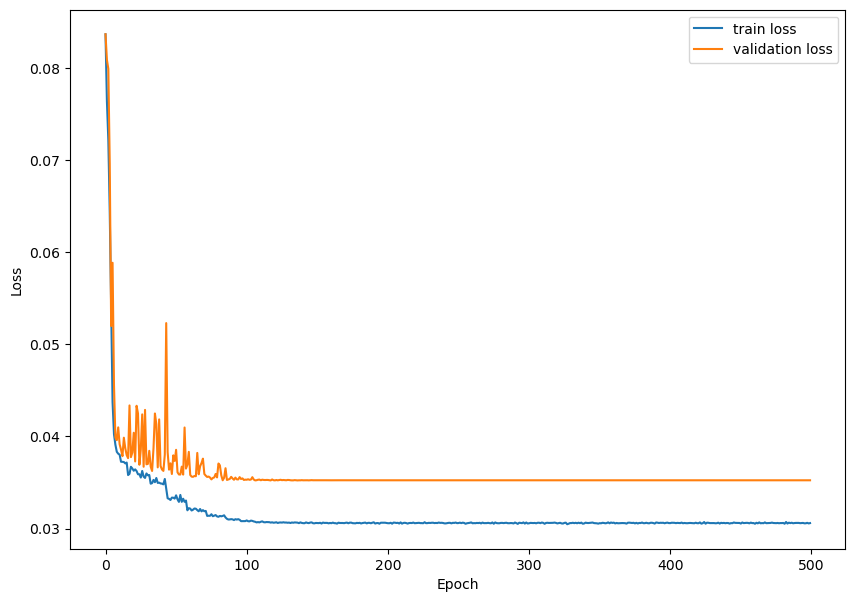

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(range(N_EPOCHS), history.history['loss'], label='train loss')
plt.plot(range(N_EPOCHS), history.history['val_loss'], label='validation loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [51]:
pred = model.predict(test_x)
df = pd.DataFrame(pred)
df

32/32 [==============================] - 0s 516us/step


,0
0,0.346833
1,0.975709
2,0.872389
3,0.554532
4,0.654982
...,...
995,0.937938
996,-0.047797
997,0.410627
998,0.387032


In [166]:
tey_eye

0      0.073463
1      0.824888
2      0.726801
3      0.103462
4      0.479768
         ...   
495    0.838311
496    0.310638
497    0.997561
498    0.910411
499    0.904922
Name: eyeRotation, Length: 500, dtype: float64

In [52]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(tey_eye, pred)**0.5
print(rmse)

0.1877056541401249


In [53]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(tey_eye, pred)
print(mae)

0.1499556158609646
